In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Angsana New'
rcParams.update({'font.size': 22})
rcParams['axes.unicode_minus'] = False

In [3]:
# df_read = pd.read_csv('data/corrected_data.csv')
# df_read = pd.read_csv('data/meter_corrected.csv')
# df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly-corrected.csv', parse_dates=["datetime"])
df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly.csv', parse_dates=["datetime"])

In [4]:
df = df_read.copy()
print(df.dtypes)

datetime    datetime64[ns]
ec                 float64
dtype: object


In [5]:
# df = df.loc[df["datetime"].dt.year==2022]
df = df.loc[(df["datetime"].dt.year==2022) & (df["datetime"].dt.hour==6) & (df["datetime"].dt.minute==0)]
df.sort_values(by=['datetime'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [6]:
# =============================================================================
# กำหนดตัวแปรที่ต้องการใช้ train ตัว model
# =============================================================================

data = df.filter(['ec'])
dataset = data.values

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [8]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

# dataset_scaled = scaler.fit_transform(dataset)

In [9]:
# n_future = 24
# n_past = 48
# step = 1

n_future = 14
n_past = 28

In [10]:
import math

train_set_len = math.ceil(len(dataset) * 0.80)
valid_set_len = math.ceil(len(dataset) * 0.10)

# # first 3yrs
# train_set_len = 26280

# # last year
# valid_set_len = 17544

In [11]:
train_set = dataset_scaled[0:train_set_len, :]

x_train = []
y_train = []

for i in range(n_past, len(train_set) - n_future + 1):
    x_train.append(train_set[i - n_past:i, 0:dataset.shape[1]])
    y_train.append(train_set[i:i + n_future, 0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [13]:
valid_set = dataset_scaled[train_set_len - n_past:train_set_len + valid_set_len, :]

x_valid = []
y_valid = []

for i in range(n_past, len(valid_set) - n_future + 1):
    x_valid.append(valid_set[i - n_past:i, 0:dataset.shape[1]])
    y_valid.append(valid_set[i:i + n_future, 0])

In [14]:
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
y_valid = np.reshape(y_valid, (y_valid.shape[0], y_valid.shape[1], 1))

In [15]:
test_set = dataset_scaled[(train_set_len + valid_set_len) - n_past:, :]
test_real = dataset[(train_set_len + valid_set_len) - n_past:, :]

x_test = []
y_test = []

for i in range(n_past, len(test_set) - n_future + 1):
    x_test.append(test_set[i - n_past:i, 0:dataset.shape[1]])
    y_test.append(test_real[i:i + n_future, 0])

In [16]:
x_test, y_test = np.array(x_test), np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

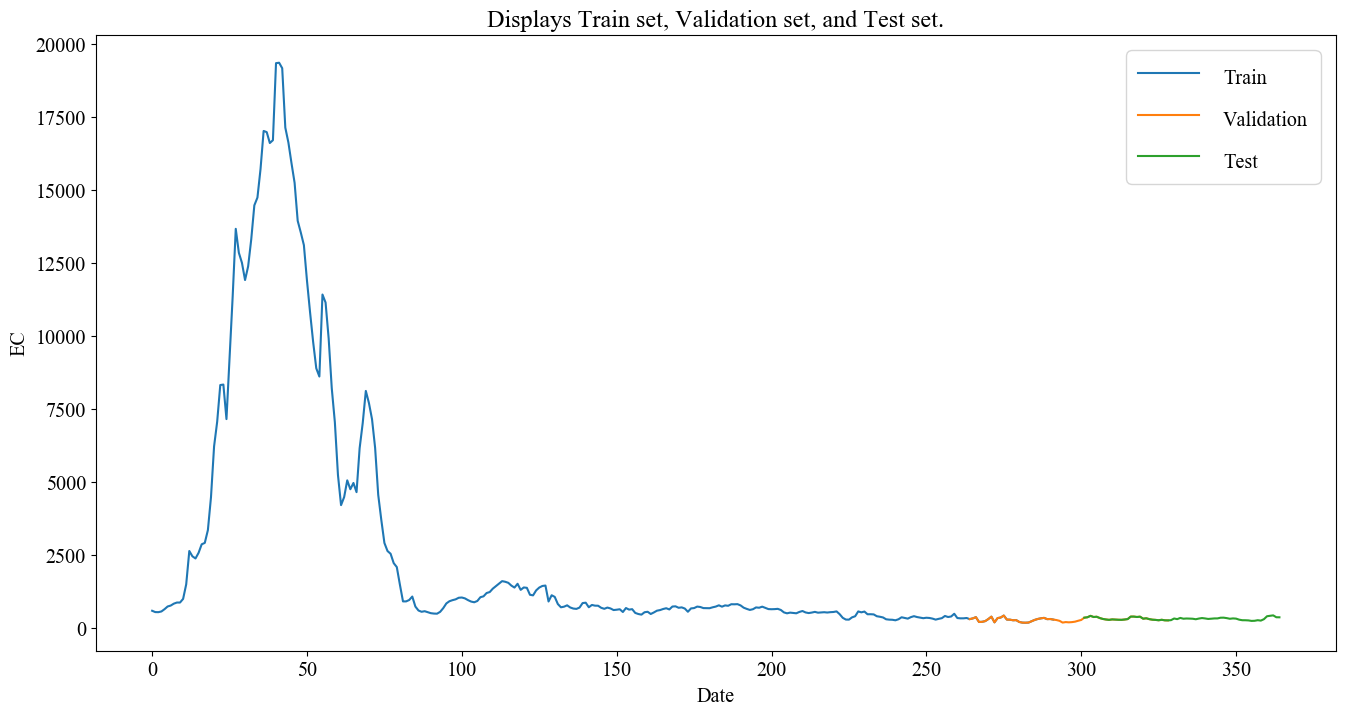

In [17]:
plt.figure(figsize=(16,8))
plt.title('Displays Train set, Validation set, and Test set.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df[0:train_set_len]["ec"], label='Train')
plt.plot(df[train_set_len - n_past:train_set_len + valid_set_len]["ec"], label='Validation')
plt.plot(df[(train_set_len + valid_set_len) - n_past:]["ec"], label='Test')
plt.legend()
plt.show()

In [18]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
# from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
# =============================================================================
# LSTM
# =============================================================================

model = Sequential()
model.add(LSTM(192, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(192, return_sequences=True))
model.add(LSTM(192, return_sequences=False))
model.add(Dense(n_future))

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(n_future))
# model.add(Dense(16))
# model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 192)           148992    
                                                                 
 lstm_1 (LSTM)               (None, 192)               295680    
                                                                 
 dense (Dense)               (None, 14)                2702      
                                                                 
Total params: 447,374
Trainable params: 447,374
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 192)           148992    
                                                                 
 lstm_1 (LSTM)               (None, 192)          

In [21]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [22]:
# checkpoint_filepath = 'checkpoint/lstm-meter-24-3-2-1-gpu-batch-24.h5'
checkpoint_filepath = 'checkpoint/lstm-14-2022-batch-24.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [23]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
11/11 [==============================] - ETA: 0s - loss: 0.0343 - mse: 0.0343
Epoch 1: val_loss improved from inf to 0.00020, saving model to checkpoint\lstm-14-2022-batch-24.h5
11/11 [==============================] - 4s 124ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 1.9921e-04 - val_mse: 1.9921e-04
Epoch 2/128
10/11 [==========================>...] - ETA: 0s - loss: 0.0193 - mse: 0.0193
Epoch 2: val_loss improved from 0.00020 to 0.00007, saving model to checkpoint\lstm-14-2022-batch-24.h5
11/11 [==============================] - 1s 50ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 7.3558e-05 - val_mse: 7.3558e-05
Epoch 3/128
11/11 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0117
Epoch 3: val_loss did not improve from 0.00007
11/11 [==============================] - 0s 44ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 6.1913e-04 - val_mse: 6.1913e-04
Epoch 4/128
11/11 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0093
Epoc

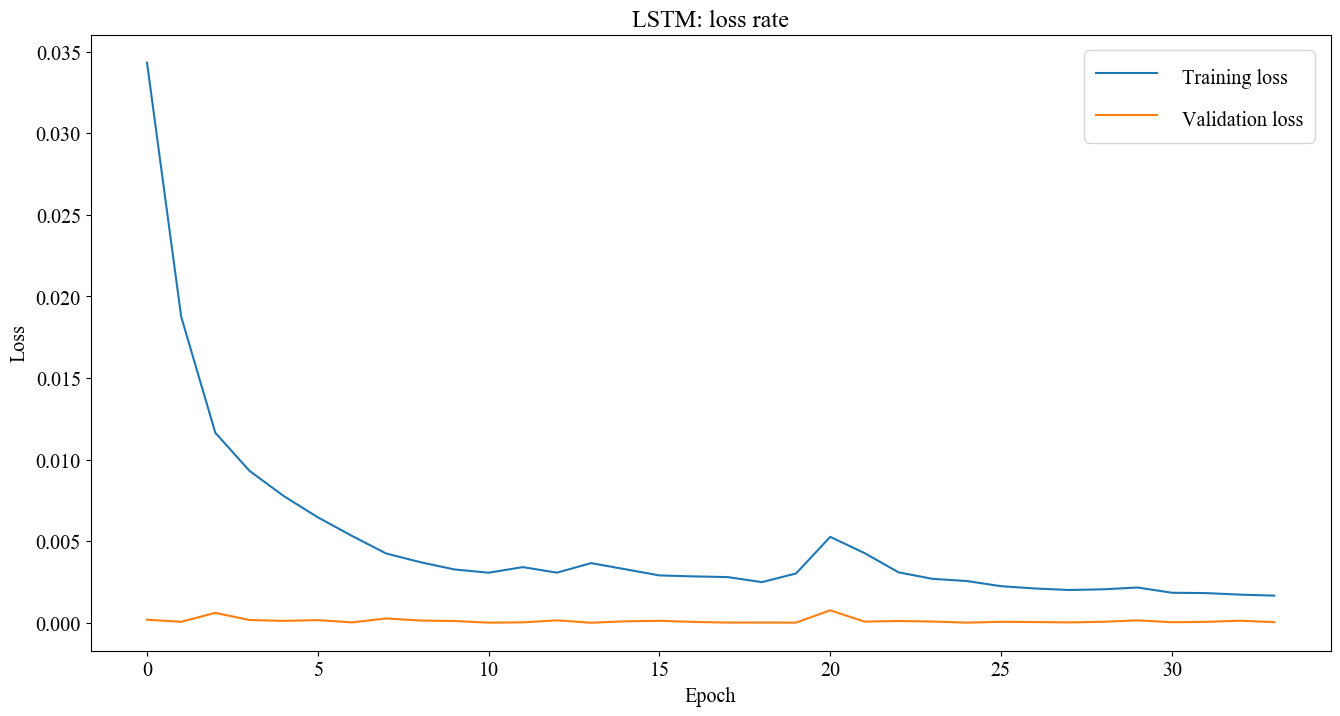

In [24]:
plt.figure(figsize=(16,8))
plt.title('LSTM: loss rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


# #%%
# from keras.models import load_model

# model = load_model('checkpoint/01-bilstm-24-3-2-1.h5')

# #%%
# pred = model.predict(x_test)

# #%%
# if dataset.shape[1] > 1:
#     pred = np.repeat(pred, dataset.shape[1], axis=-1)

# #%%
# y_pred = scaler.inverse_transform(pred)[:,0]

# #%%
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

# #%%
# from sklearn.metrics import mean_squared_error

# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'RMSE of Bi-LSTM = {rmse}')            

# #%%
# # rmse = np.sqrt(np.mean(np.square((y_test - y_pred))))
# # print(rmse)

# #%%
# rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
# print(f'RMSPE of Bi-LSTM = {rmspe}')


# #%%
# df_compare = pd.DataFrame({'Actual EC':df['ec_corrected'][train_set_len + valid_set_len:]})
# df_compare['Predicted EC'] = y_pred

# #%%
# plt.figure(figsize=(16,8))
# plt.title('Displays Actual EC vs. Predicted EC.')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.plot(df_compare['Actual EC'], label='Actual')
# plt.plot(df_compare['Predicted EC'], label='Predicted')
# plt.legend()
# plt.show()

# #%%
# plt.figure(figsize=(16,8))
# plt.title('Displays All Actual EC vs. Predicted EC.')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.plot(df['ec_new_.5'], label='All Actual EC')
# plt.plot(df_compare['Predicted EC'], label='Predicted')
# plt.legend()
# plt.show()

In [25]:
from keras.models import load_model

model = load_model('checkpoint/lstm-14-2022-batch-24.h5')

In [26]:
pred = model.predict(x_test)

1/1 [==============================] - 1s 635ms/step


In [27]:
rpred = None

In [28]:
for i in range(pred.shape[1]):
    tpred = pred[:,i]
    tpred = np.reshape(tpred, (tpred.shape[0], 1))
    tpred = np.repeat(tpred, dataset.shape[1], axis=-1)
    tpred = scaler.inverse_transform(tpred)[:,0]
    tpred = np.reshape(tpred, (tpred.shape[0], 1))
    if rpred is None:
        rpred = tpred
    else:
        rpred = np.append(rpred, tpred, axis=1)

In [29]:
y_pred = rpred[:,0]
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [30]:
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

In [31]:
y_real = y_test[:,0]
y_real = np.reshape(y_real, (y_real.shape[0], 1))

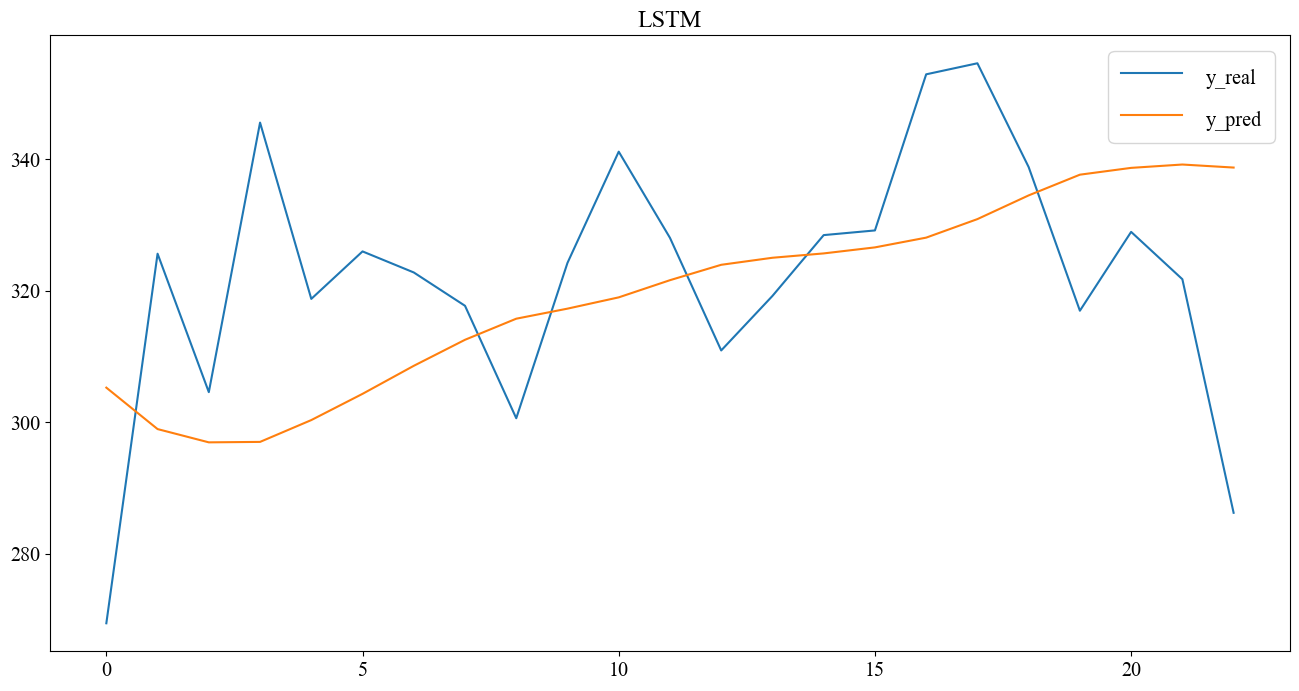

In [32]:
plt.figure(figsize=(16,8))
plt.title('LSTM')
plt.plot(y_real, label='y_real')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, rpred, squared=False)
print("RMSE =",rmse)

RMSE = 58.62441391240733


In [34]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE
mape = mean_absolute_percentage_error(y_test, rpred)
print(f'MAPE = {mape}')

MAPE = 0.16268642828538887
